# === 1. Import Library dan Load Dataset  ===   ===


In [29]:
!pip install wordcloud


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

In [13]:
train_data = pd.read_csv('Dataset/train.csv')
test_data = pd.read_csv('Dataset/test.csv')

In [16]:
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [14]:
train_data.tail()

,id,label,tweet
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."
31961,31962,0,thank you @user for you follow


In [15]:
train_data.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [17]:
train_data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

# === 2. Preprocessing Data  ===


In [18]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faliq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faliq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Faliq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
text_column = 'tweet'

In [20]:
# --- Kamus slang umum di media sosial ---
slang_dict = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "ya": "you",
    "btw": "by the way",
    "idk": "i dont know",
    "thx": "thanks",
    "pls": "please",
    "imo": "in my opinion",
    "bday": "birthday",
    "luv": "love",
    "b4": "before",
    "gr8": "great",
    "w/": "with",
    "w/o": "without"
}

# --- Fungsi normalisasi slang ---
def normalize_tokens(tokens):
    return [slang_dict.get(word, word) for word in tokens]

In [21]:
# --- Fungsi utama preprocessing ---
def clean_text(text):
    # 1. Hapus URL, mention, hashtag, karakter non-huruf
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower().strip()
    return text

In [22]:
# --- Terapkan langkah-langkah preprocessing ---
text_column = 'tweet'  # pastikan ini sesuai kolom dataset kamu

# 1. Bersihkan teks mentah
train_data['clean_text'] = train_data[text_column].apply(clean_text)

# 2. Tokenisasi
train_data['tokens'] = train_data['clean_text'].apply(word_tokenize)

# 3. Normalisasi slang (misalnya 'u' → 'you')
train_data['tokens'] = train_data['tokens'].apply(normalize_tokens)

# 4. Stopword removal dengan pengecualian kata penting
stop_words = set(stopwords.words('english'))

# Kata penting yang tetap disimpan
keep_words = {'i', 'you', 'your', 'yours', 'our', 'ours', 'we', 'us', 'not', 'no'}
custom_stopwords = stop_words - keep_words

train_data['tokens'] = train_data['tokens'].apply(
    lambda tokens: [w for w in tokens if w not in custom_stopwords]
)

# 5. Lemmatization
lemmatizer = WordNetLemmatizer()
train_data['lemmatized'] = train_data['tokens'].apply(
    lambda tokens: [lemmatizer.lemmatize(w) for w in tokens]
)

# --- Tampilkan hasil akhir ---
print("=== Hasil Preprocessing Teks ===")
display(train_data[['tweet', 'clean_text', 'tokens', 'lemmatized']].head(10))

=== Hasil Preprocessing Teks ===


,tweet,clean_text,tokens,lemmatized
0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,"[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunctional, selfish, drag, kid, dy..."
1,@user @user thanks for #lyft credit i can't us...,thanks for credit i cant use cause they dont ...,"[thanks, credit, i, cant, use, cause, dont, of...","[thanks, credit, i, cant, use, cause, dont, of..."
2,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, your, majesty]"
3,#model i love u take with u all the time in ...,i love u take with u all the time in ur,"[i, love, you, take, you, time, your]","[i, love, you, take, you, time, your]"
4,factsguide: society now #motivation,factsguide society now,"[factsguide, society]","[factsguide, society]"
5,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before they leav...,"[huge, fan, fare, big, talking, leave, chaos, ...","[huge, fan, fare, big, talking, leave, chaos, ..."
6,@user camping tomorrow @user @user @user @use...,camping tomorrow danny,"[camping, tomorrow, danny]","[camping, tomorrow, danny]"
7,the next school year is the year for exams.ð...,the next school year is the year for exams can...,"[next, school, year, year, exams, cant, think]","[next, school, year, year, exam, cant, think]"
8,we won!!! love the land!!! #allin #cavs #champ...,we won love the land,"[we, love, land]","[we, love, land]"
9,@user @user welcome here ! i'm it's so #gr...,welcome here im its so,"[welcome, im]","[welcome, im]"


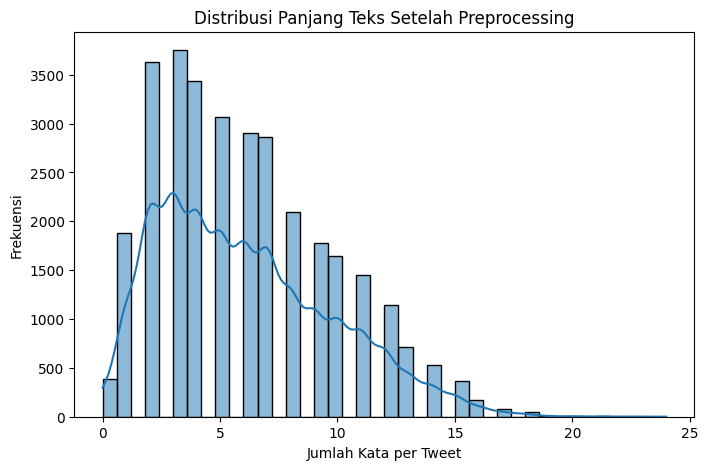

In [ ]:
train_data['token_length'] = train_data['lemmatized'].apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(train_data['token_length'], bins=40, kde=True)
plt.title('Distribusi Panjang Teks Setelah Preprocessing')
plt.xlabel('Jumlah Kata per Tweet')
plt.ylabel('Frekuensi')
plt.show()

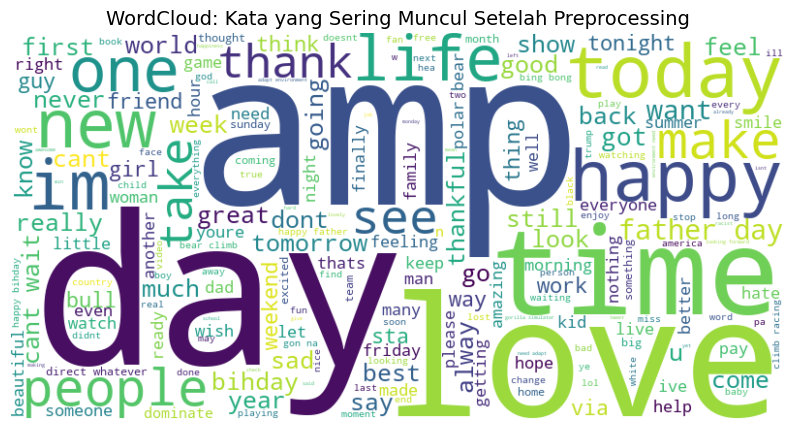

In [ ]:
all_words = ' '.join([' '.join(tokens) for tokens in train_data['lemmatized']])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud: Kata yang Sering Muncul Setelah Preprocessing', fontsize=14)
plt.show()

C:\Users\Faliq\AppData\Local\Temp\ipykernel_30864\2903961292.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=freq_df, palette='viridis')


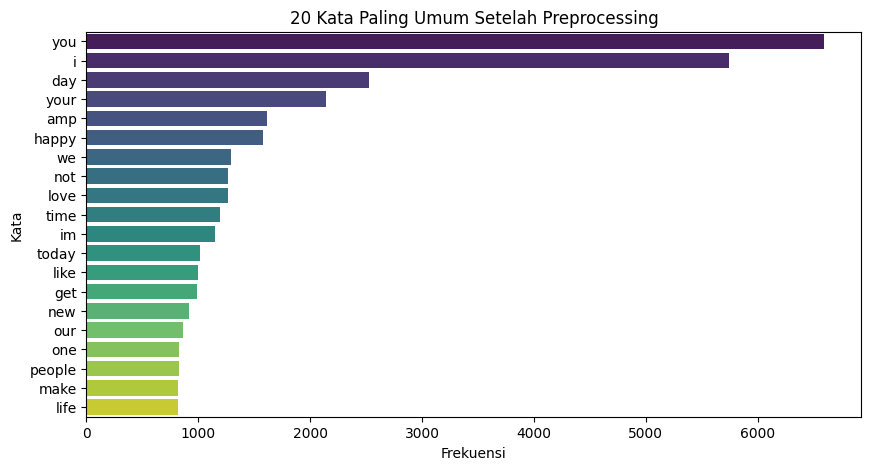

In [ ]:
word_freq = Counter([word for tokens in train_data['lemmatized'] for word in tokens])
common_words = word_freq.most_common(20)

# Ubah jadi DataFrame untuk visualisasi
freq_df = pd.DataFrame(common_words, columns=['word', 'count'])

plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='word', data=freq_df, palette='viridis')
plt.title('20 Kata Paling Umum Setelah Preprocessing')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

# === 3. Inisiasi input dan target class  ===

In [23]:
# --- a. Pisahkan fitur (input) dan target (label) ---
X = train_data['lemmatized'].apply(lambda tokens: ' '.join(tokens))  # ubah list token jadi kalimat
y = train_data['label']

In [24]:
# --- b. Split data menjadi training (80%) dan validation (20%) ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [25]:
print("=== Informasi Dataset ===")
print(f"Total data     : {len(train_data)}")
print(f"Training set   : {len(X_train)} data")
print(f"Validation set : {len(X_val)} data")

# --- (Opsional) Cek sampel hasil split ---
print("\nContoh data training:")
display(pd.DataFrame({'tweet': X_train.head(5), 'label': y_train.head(5)}))

=== Informasi Dataset ===
Total data     : 31962
Training set   : 25569 data
Validation set : 6393 data

Contoh data training:


,tweet,label
26247,first order something black amp sexy collection,0
13681,although im told andrew jackson also,1
25676,video enough crap,1
14544,monaco podium time guy maybe,0
25411,wow u open amateur hour fox show golf quite pe...,0


# === 4. Bangun model Recurrent Neural Network (RNN)  ===

In [35]:
# --- 1. Tokenisasi dan padding ---
max_words = 10000   # jumlah maksimum kata yang akan dipertimbangkan
max_len = 100       # panjang maksimum tiap urutan teks

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

In [ ]:
# --- 2. Bangun model RNN (LSTM) ---
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

NameError: name 'vocab_size' is not defined

In [41]:
# --- 3. Kompilasi model ---
model.compile(
    loss='binary_crossentropy',    # gunakan 'categorical_crossentropy' jika multi-class
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,419,905 (5.42 MB)

 Trainable params: 1,419,905 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# --- 4. Latih model ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 37s 88ms/step - accuracy: 0.9289 - loss: 0.2690 - val_accuracy: 0.9299 - val_loss: 0.2539
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.9298 - loss: 0.2607 - val_accuracy: 0.9299 - val_loss: 0.2550
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 33s 81ms/step - accuracy: 0.9298 - loss: 0.2600 - val_accuracy: 0.9299 - val_loss: 0.2549
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9298 - loss: 0.2589 - val_accuracy: 0.9299 - val_loss: 0.2557


# === 5. Evaluasi model  ===

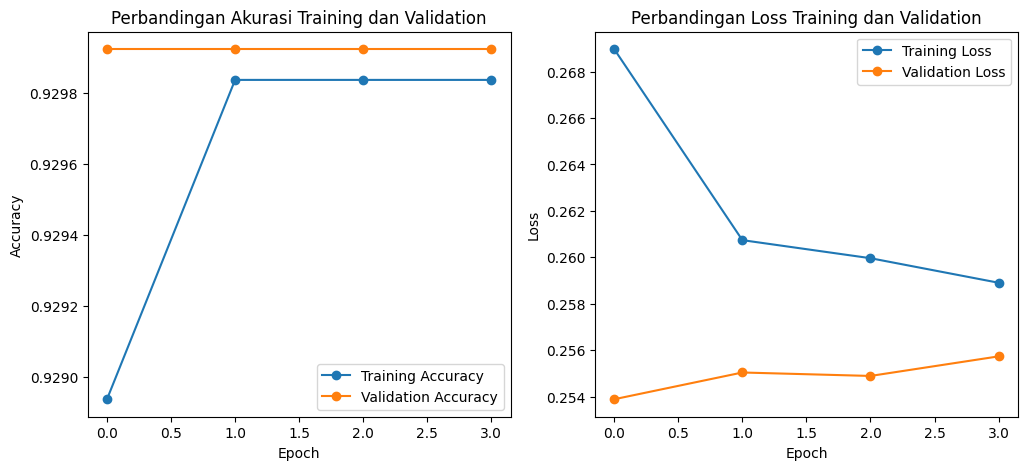

In [51]:
plt.figure(figsize=(12,5))

# Plot akurasi training dan validasi
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Perbandingan Akurasi Training dan Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss training dan validasi
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Perbandingan Loss Training dan Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [52]:
# ============================================================
# b. Classification Report pada data validasi
# ============================================================

# Prediksi pada data validasi
y_pred_val = (model.predict(X_val_pad) > 0.5).astype("int32")

print("\n=== Classification Report (Data Validasi) ===")
print(classification_report(y_val, y_pred_val, target_names=['Negatif', 'Positif']))

# Hitung akurasi validasi
acc_val = accuracy_score(y_val, y_pred_val)
print(f"\nAkurasi Validasi: {acc_val*100:.2f}%")

if acc_val >= 0.85:
    print("🎯 Target tercapai: Akurasi di atas 85%")
else:
    print("⚠️ Target belum tercapai, coba tuning model (neuron, epoch, atau dropout).")

200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step

=== Classification Report (Data Validasi) ===
              precision    recall  f1-score   support

     Negatif       0.93      1.00      0.96      5945
     Positif       0.00      0.00      0.00       448

    accuracy                           0.93      6393
   macro avg       0.46      0.50      0.48      6393
weighted avg       0.86      0.93      0.90      6393


Akurasi Validasi: 92.99%
🎯 Target tercapai: Akurasi di atas 85%


d:\UMM\KULIAH\KULIAH smstr 7\Pembelajaran Mesin\Praktikum\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\UMM\KULIAH\KULIAH smstr 7\Pembelajaran Mesin\Praktikum\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\UMM\KULIAH\KULIAH smstr 7\Pembelajaran Mesin\Praktikum\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

In [55]:
# ============================================================
# c. Preprocessing Data Test + Prediksi
# ============================================================

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # hapus URL
    text = re.sub(r'@\w+', '', text)                     # hapus mention
    text = re.sub(r'#', '', text)                        # hapus tanda #
    text = re.sub(r'[^A-Za-z\s]', '', text)              # hapus karakter selain huruf
    text = text.lower()                                  # ubah ke huruf kecil
    return text

# Load data test
test_data = pd.read_csv("Dataset/test.csv")

# Bersihkan teks
test_data['clean_text'] = test_data['tweet'].apply(clean_text)

# Tokenisasi
test_data['tokens'] = test_data['clean_text'].apply(word_tokenize)

# Hapus stopwords
stop_words = set(stopwords.words('english'))
test_data['tokens'] = test_data['tokens'].apply(lambda x: [w for w in x if w not in stop_words])

# Gabungkan kembali token menjadi teks
test_data['final_text'] = test_data['tokens'].apply(lambda x: ' '.join(x))

# Tokenisasi & padding (harus sama seperti training)
X_test_seq = tokenizer.texts_to_sequences(test_data['final_text'])
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Prediksi
y_pred_test = (model.predict(X_test_pad) > 0.5).astype("int32")

# Simpan hasil
test_data['predicted_label'] = y_pred_test
test_data['predicted_sentiment'] = test_data['predicted_label'].map({0: 'Negatif', 1: 'Positif'})

print("\n=== Contoh Hasil Prediksi Data Test ===")
display(test_data[['id', 'tweet', 'predicted_sentiment']].head(10))

538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step

=== Contoh Hasil Prediksi Data Test ===


,id,tweet,predicted_sentiment
0,31963,#studiolife #aislife #requires #passion #dedic...,Negatif
1,31964,@user #white #supremacists want everyone to s...,Negatif
2,31965,safe ways to heal your #acne!! #altwaystohe...,Negatif
3,31966,is the hp and the cursed child book up for res...,Negatif
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",Negatif
5,31968,choose to be :) #momtips,Negatif
6,31969,something inside me dies ð¦ð¿â¨ eyes nes...,Negatif
7,31970,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...,Negatif
8,31971,@user @user @user i will never understand why...,Negatif
9,31972,#delicious #food #lovelife #capetown mannaep...,Negatif
